# Fama-Macbeth regressions: the case of FX

#### Author: Gustavo Soares

## Introduction

The problem with Fama-French portfolios is that it is difficult to include a large set of controls when examining the relation. Unlike portfolio analysis, regression analysis allows us to control for a large set of other variables when examining the relation of interest. 

In this notebook, we present a few regression techniques and exemplify its implementation using the data from FX. Specifically,
we illustrate how the techniques with the excess returns of a currency on the left-hand-side (LHS) of the regression and a measure of carry and value of a currency.

Let's import what we are going to need and grab the data:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('fx_data.xlsx', sheet_name='trackers', index_col=0, engine='openpyxl').astype(float)
df.index = pd.to_datetime(df.index)
carry = pd.read_excel('fx_data.xlsx', sheet_name='carry', index_col=0, engine='openpyxl').astype(float)
carry.index = pd.to_datetime(carry.index)
value = pd.read_excel('fx_data.xlsx', sheet_name='value', index_col=0, engine='openpyxl').astype(float)
value.index = pd.to_datetime(value.index)

## Returns and Characteristics

### The LHS: returns

The trackers were constructed by tracking forward contracts that get systematically rolled at the 4pm LND fixing (except for Asian currencies where we use the 6am LND fixing). So, what we have for in our trackers data, is the excess return index of each currency $i$ in USD. Hence, we can define:

$$
y_{i,t} \equiv r_{i,t+h} \equiv \frac{I_{i,t+h}}{I_{i,t}}
$$

as the return from time $t$ to time $t+h$ for some arbitrary value of $h>0$. This is our LHS variable, the dependent variable in our regressions.

Let's look at four different cases:

In [3]:
y_daily = np.log(df).diff(1).shift(-1).dropna() # daily returns
y_weekly = np.log(df.resample('W').last()).diff(1).shift(-1).dropna() # weekly returns
y_monthly = np.log(df.resample('M').last()).diff(1).shift(-1).dropna() # monthly returns
y_21 = np.log(df).diff(21).shift(-21).dropna() # rolling monthly returns

Below, we will focus on the ```y_monthly``` but you should try out the other cases to see the difference in results.

### The RHS: characteristics

Note that to trade at the value I_{i,t}, the investment decision has be made during the business day $t$ with information obtained up to the previous day, $t-1$. So, the currency characteristics vector is defined as:

$$
C_{i, t} \equiv \begin{bmatrix} c_{i,t-1} \\ v_{i,t-1} \end{bmatrix}
$$

where $c_{i,t-1}$ is a measure of carry based on the ratio of forward and spot exchange rates and $v_{i,t-1}$ is a value measure of the currency based on the ratio of the spot exchange rates vs. ppp-exchange rates.

## The factor model

We will depart from a factor model where

$$
y_{i,t} \equiv r_{i,t+h} = \alpha_{i,t} + \beta_{i,t}'\lambda_{t} + \eta_{i,t}
$$

The set of factors contained in the vector $\lambda_{t}$ may be latent and unobservable and ultimately unkown to us. However, they may be related to intrinsic currency characteristics like carry and value. We want to check whether the future returns of a currency, $r_{i,t+h}$ rises with the characteristics in the vector $C_{i,t}$. Why would this happen? Within a factor model framework, this may happen because the currency with that set of characteristic $C_{i,t}$ may have a high $\beta_{i,t}$ with respect to the unlerlying factor vector $\lambda_{t}$. For example, the beta vector may be a function of those characteristics $\beta_{i,t} = \gamma_{0} + \gamma_{1}'C_{i,t}$ and therefore:

$$
y_{i,t} \equiv r_{i,t+h} = \alpha_{i,t} + \beta_{i,t}'\lambda_{t} + \eta_{i,t}
$$

$$
y_{i,t} \equiv r_{i,t+h} = \alpha_{i,t} + (\gamma_{0} + \gamma_{1}'C_{i,t})'\lambda_{t} + \eta_{i,t+1} = \delta_{i,t} + \xi_{t}'C_{i,t} + \eta_{i,t}
$$

where $ \delta_{i,t} \equiv \alpha_{i,t} + \gamma_{0}'\lambda_{t}$ and $\xi_{t} \equiv \gamma_{1}\lambda_{t}$. So, we estimate a regression directly on characteristics, $C_{i,t}$.

## The pooled regression

In the pooled regression we assume:

* $\delta_{i,t} = \delta$ for all $i$ and $t$
* $\xi_{t} = \xi$ for all $t$

So, we have the regression:

$$
y_{i,t} \equiv r_{i,t+h} = \delta + \xi'C_{i,t} + \eta_{i,t}
$$

In [4]:
y = y_monthly.copy()
pooled_data = pd.DataFrame()
for ccy in y.columns:
    if ccy in carry.columns and ccy in value.columns:
        X1 = carry[ccy].shift(1)
        X2 = value[ccy].shift(1)            
        yX = pd.concat([y[ccy], X1, X2], axis=1, sort=True).fillna(method='ffill')
        yX = yX.loc[y[ccy].dropna().index].dropna()
        yX.index = pd.MultiIndex.from_tuples([(x, ccy) for x in yX.index], names=['date','ccy'])
        yX.columns = ['returns', 'carry', 'value']
        pooled_data = pooled_data.append(yX.dropna().astype(float))

model = sm.OLS(pooled_data.iloc[:,[0]],sm.add_constant(pooled_data.iloc[:,[1,2]])).fit(cov_type='HAC',
                                                                                       cov_kwds={'maxlags':6})
print(model.summary())

winsorized_x = pd.DataFrame(stats.mstats.winsorize(pooled_data.iloc[:,[1,2]].values, limits=.01),
                            columns=['carry', 'value'],
                           index=pooled_data.index)
model = sm.OLS(pooled_data.iloc[:,[0]], sm.add_constant(winsorized_x)).fit(cov_type='HAC',
                                                                                      cov_kwds={'maxlags':6})
print(model.summary())

model = sm.OLS(np.sign(pooled_data.iloc[:,[0]]), sm.add_constant(pooled_data.iloc[:,[1,2]])).fit(cov_type='HAC',
                                                                                                 cov_kwds={'maxlags':6})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.88
Date:                Wed, 05 May 2021   Prob (F-statistic):           7.12e-06
Time:                        14:01:34   Log-Likelihood:                 10650.
No. Observations:                5495   AIC:                        -2.129e+04
Df Residuals:                    5492   BIC:                        -2.127e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.495      0.1

As an exercise, try to run these regressions for other definitions of returns. Pay attention to the case of rolling monthly returns. Are the beta's still consistent? What about inference? Can we trust the p-values in this case?

### Cross-Sectional Regressions

In the cross-sectional regressions we assume:

* $\delta_{i,t} = \delta_{t}$ for all $i$

So, we have the regression:

$$
y_{i,t} \equiv r_{i,t+h} = \delta_{t} + \xi_{t}'C_{i,t} + \eta_{i,t}.
$$

Note that since both $\delta_{t}$ and $\xi_{t}$ vary for every $t$, this regression is not exactly a panel regression with time fixed effects. In fact, these are simply, a collection of regressions, one for each point in time $t$. Each period $t$ will produce different estimates for $\delta_{t}$ and $\xi_{t}$. Let's do that below and also estimate $\zeta_{i,t} = \delta_{t} + \eta_{i,t}$:

In [5]:
pcsr = pd.DataFrame()
zeta = pd.DataFrame()
for t in pooled_data.index.get_level_values(0).unique():
    yt = pooled_data.loc[t].iloc[:,[0]]
    xt = pooled_data.loc[t].iloc[:,[1,2]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HC3')
    coef = model.params.to_frame(t).T
    coef['r2'] = model.rsquared
    zeta = zeta.append((model.resid + model.params[0]).to_frame(t).T)
    pcsr = pcsr.append(coef)

Let's plot the results of our estimates for $\delta_{t}$ and $\xi_{t}$:

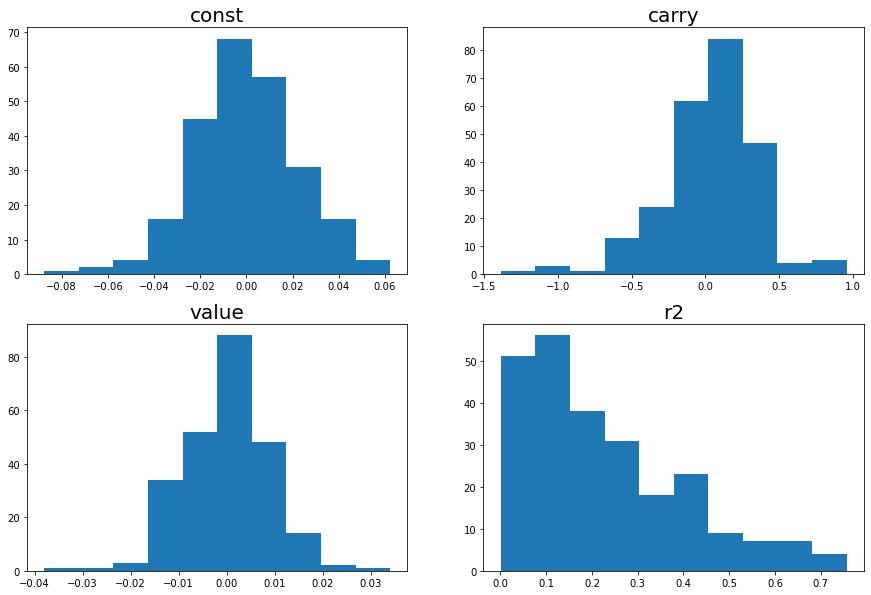

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0, 0].hist(pcsr.iloc[:,[0]])
axs[0, 0].set_title(pcsr.columns[0], fontsize=20)
axs[0, 1].hist(pcsr.iloc[:,[1]])
axs[0, 1].set_title(pcsr.columns[1], fontsize=20)
axs[1, 0].hist(pcsr.iloc[:,[2]])
axs[1, 0].set_title(pcsr.columns[2], fontsize=20)
axs[1, 1].hist(pcsr.iloc[:,[3]])
axs[1, 1].set_title(pcsr.columns[3], fontsize=20)
plt.show()

In [7]:
pcsr.describe()

,const,carry,value,r2
count,244.000000,244.000000,2.440000e+02,244.000000
mean,-0.000098,0.034080,-1.226303e-07,0.224821
std,0.022598,0.320334,9.019349e-03,0.175172
min,-0.087573,-1.387733,-3.801895e-02,0.001086
25%,-0.013974,-0.142287,-5.116890e-03,0.089875
50%,-0.000750,0.080837,4.640679e-04,0.176836
75%,0.013941,0.242547,5.907595e-03,0.334759
max,0.062282,0.957819,3.403513e-02,0.756390


In the traditional Fama-Macbeth approach, now we test signficance of the $\xi_{t}$ parameters using:

$$
\hat{\xi} = T^{-1}\sum_{t}{\hat{\xi}_{t}} \\
Var[\hat{\xi}] = T^{-1}\sum_{t}(\hat{\xi}_{t} - \hat{\xi})(\hat{\xi}_{t} - \hat{\xi})´
$$

like this:

In [8]:
(pcsr.mean()/(pcsr.std()/np.sqrt(pcsr.count())))[['carry', 'value']]

carry    1.661827
value   -0.000212
dtype: float64

As an exercise, calcualte the p-values of these t-stats above!

Let's look at our estimates for $\zeta_{i,t} = \delta_{t} + \eta_{i,t}$:

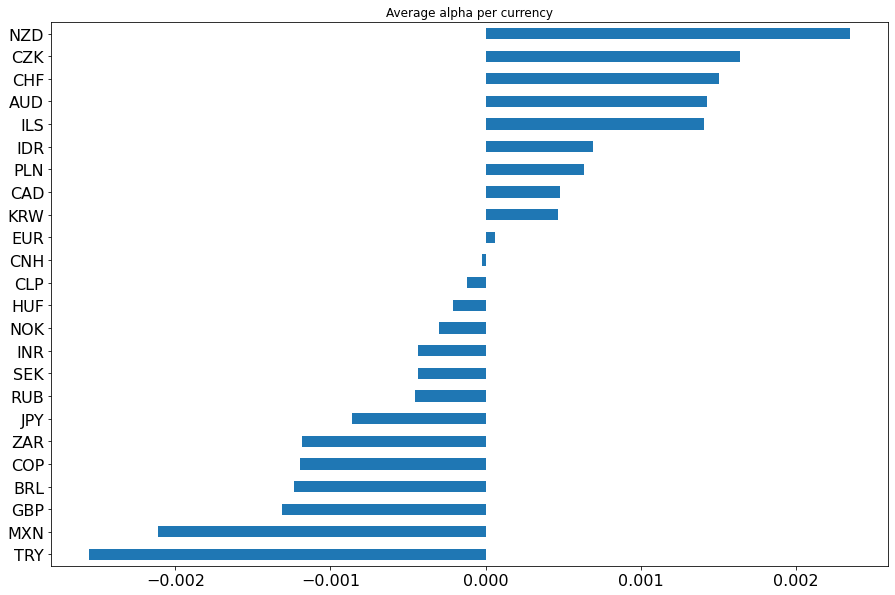

In [9]:
zeta.mean().sort_values().plot(kind='barh', figsize=(15,10), fontsize=16)
plt.title('Average alpha per currency')
plt.show()

You can test if the coefficients $\zeta_{i,t}$ are statisticatlly significant using the below:

$$
\hat{\zeta} = T^{-1}\sum_{t}{\hat{\zeta}_{t}} = T^{-1}\sum_{t}{\begin{bmatrix} \hat{\zeta}_{1,t} \\ \vdots \\ \hat{\zeta}_{N,t} \end{bmatrix}} \\
$$

$$
COV(\hat{\zeta}) = T^{-2}\sum_{t}{(\hat{\zeta}_{t} - \hat{\zeta})(\hat{\zeta}_{t} - \hat{\zeta})'}
$$

and the calculating a Wald statistic:

$$
\hat{\zeta}'COV(\hat{\zeta})^{-1}\hat{\zeta}
$$

which has chi-squared distribution (with degrees of freedom equal to the number of currencies, $N$, minus 1).

Be careful with your estimate for $COV(\hat{\zeta})$, without the dropna(), that matrix need not to be postive definite!

In [10]:
np.linalg.det(zeta.cov())

-1.803564034334476e-84

In [11]:
np.linalg.det(zeta.dropna().cov())

3.87854816529201e-86

In [12]:
zeta.dropna().cov()

,AUD,BRL,CAD,CHF,CLP,COP,CZK,EUR,GBP,HUF,...,SEK,ZAR,IDR,INR,KRW,TRY,PLN,ILS,RUB,CNH
AUD,0.000642,0.000514,0.000419,0.000355,0.000479,0.000592,0.000511,0.000369,0.000302,0.000514,...,0.000439,0.000577,0.000422,0.000352,0.000387,0.000153,0.000555,0.000231,0.000496,0.000125
BRL,0.000514,0.001554,0.000418,0.000603,0.000497,0.000784,0.000754,0.000567,0.000405,0.000744,...,0.000578,0.000715,0.000460,0.000444,0.000514,0.000248,0.000768,0.000290,0.000435,0.000186
CAD,0.000419,0.000418,0.000530,0.000264,0.000413,0.000606,0.000519,0.000364,0.000307,0.000521,...,0.000400,0.000484,0.000304,0.000257,0.000309,0.000111,0.000503,0.000220,0.000543,0.000124
CHF,0.000355,0.000603,0.000264,0.000681,0.000364,0.000508,0.000520,0.000403,0.000250,0.000529,...,0.000436,0.000558,0.000335,0.000356,0.000386,0.000192,0.000595,0.000271,0.000446,0.000121
CLP,0.000479,0.000497,0.000413,0.000364,0.000837,0.000689,0.000508,0.000373,0.000276,0.000605,...,0.000426,0.000671,0.000312,0.000233,0.000390,0.000163,0.000565,0.000174,0.000557,0.000175
COP,0.000592,0.000784,0.000606,0.000508,0.000689,0.001430,0.000771,0.000558,0.000472,0.000797,...,0.000614,0.000752,0.000420,0.000322,0.000589,0.000159,0.000808,0.000361,0.000915,0.000201
CZK,0.000511,0.000754,0.000519,0.000520,0.000508,0.000771,0.000966,0.000685,0.000451,0.000896,...,0.000680,0.000631,0.000440,0.000359,0.000464,0.000289,0.000889,0.000296,0.000708,0.000166
EUR,0.000369,0.000567,0.000364,0.000403,0.000373,0.000558,0.000685,0.000565,0.000336,0.000690,...,0.000542,0.000467,0.000288,0.000290,0.000357,0.000299,0.000679,0.000232,0.000492,0.000134
GBP,0.000302,0.000405,0.000307,0.000250,0.000276,0.000472,0.000451,0.000336,0.000576,0.000441,...,0.000359,0.000346,0.000219,0.000240,0.000282,0.000171,0.000462,0.000206,0.000476,0.000139
HUF,0.000514,0.000744,0.000521,0.000529,0.000605,0.000797,0.000896,0.000690,0.000441,0.001141,...,0.000687,0.000682,0.000400,0.000331,0.000476,0.000345,0.000912,0.000275,0.000760,0.000167


You can test if the coefficients $\zeta_{i,t}$ are statisticatlly signficant using the below which have chi-squared distribution (with degrees of freedom equal to the number of currencies minus 1):

In [13]:
np.matmul(np.matmul(zeta.dropna().mean(),np.linalg.inv(zeta.dropna().cov())),zeta.dropna().mean())

0.4446699108616945

As an exercise, calcualte the p-values of these t-stats above!

Let's look at our estimates for $\zeta_{i,t} = \delta_{t} + \eta_{i,t}$:

We can also aggregate the stats by year like this:

In [14]:
pcsr['year'] = [d.year for d in pcsr.index]
pcsr.groupby('year').mean()

,const,carry,value,r2
year,,,,
2000,-0.005709,0.085786,-0.002530,0.260413
2001,-0.005062,0.169739,-0.007052,0.290260
2002,0.012383,0.018896,-0.001420,0.259712
2003,0.008654,0.092014,-0.000437,0.219368
2004,0.006165,0.083098,-0.000581,0.254325
2005,-0.002636,0.136085,0.000523,0.279269
2006,0.001313,0.030750,0.000552,0.315099
2007,0.010867,0.081161,-0.002064,0.204266
2008,-0.017716,-0.058140,0.003557,0.267651


Or run rolling regressions like these:

In [15]:
rolling_time_years = 5
pcsr = pd.DataFrame()
zeta = pd.DataFrame()
for t in pooled_data.index.get_level_values(0).unique()[5*12:]:
    rolling_dates = [d for d in pooled_data.index.get_level_values(0).unique() if d<=t][-5*12:]
    yt = pooled_data.loc[rolling_dates].iloc[:,[0]]
    xt = pooled_data.loc[rolling_dates].iloc[:,[1,2]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HC3')
    coef = model.params.to_frame(t).T
    coef['r2'] = model.rsquared
    zeta = zeta.append((model.resid + model.params[0]).to_frame(t).T)
    pcsr = pcsr.append(coef)

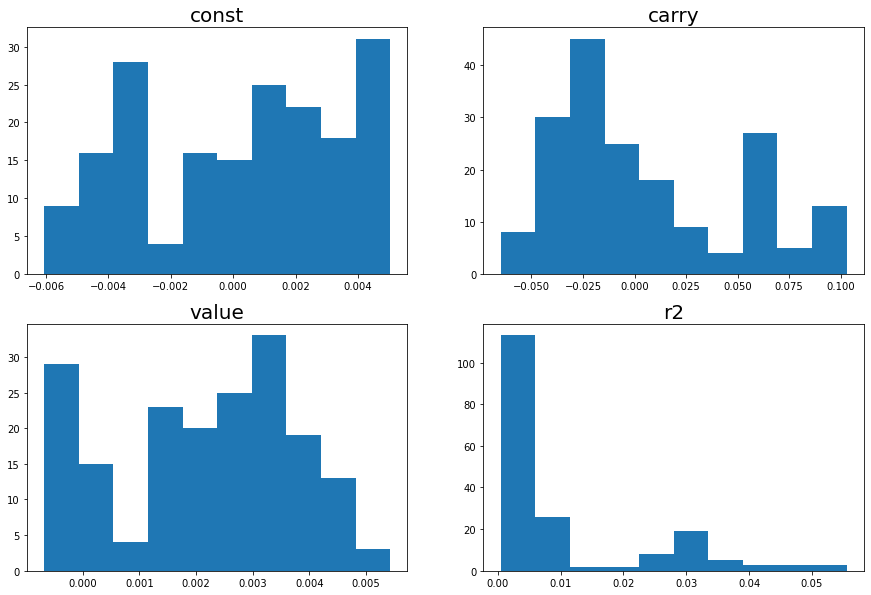

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0, 0].hist(pcsr.iloc[:,[0]])
axs[0, 0].set_title(pcsr.columns[0], fontsize=20)
axs[0, 1].hist(pcsr.iloc[:,[1]])
axs[0, 1].set_title(pcsr.columns[1], fontsize=20)
axs[1, 0].hist(pcsr.iloc[:,[2]])
axs[1, 0].set_title(pcsr.columns[2], fontsize=20)
axs[1, 1].hist(pcsr.iloc[:,[3]])
axs[1, 1].set_title(pcsr.columns[3], fontsize=20)
plt.show()

In [17]:
pcsr.describe()

,const,carry,value,r2
count,184.000000,184.000000,184.000000,184.000000
mean,0.000253,0.005908,0.002147,0.010941
std,0.003262,0.045008,0.001608,0.013114
min,-0.006059,-0.064873,-0.000677,0.000491
25%,-0.003012,-0.028033,0.001028,0.002729
50%,0.000789,-0.010111,0.002414,0.004637
75%,0.003148,0.051649,0.003368,0.010340
max,0.005032,0.102886,0.005427,0.055520


As an exercise, try using this [here](https://www.statsmodels.org/stable/examples/notebooks/generated/rolling_ls.html) for the rolling regressions.

Also, rank regresssions are quite common too:

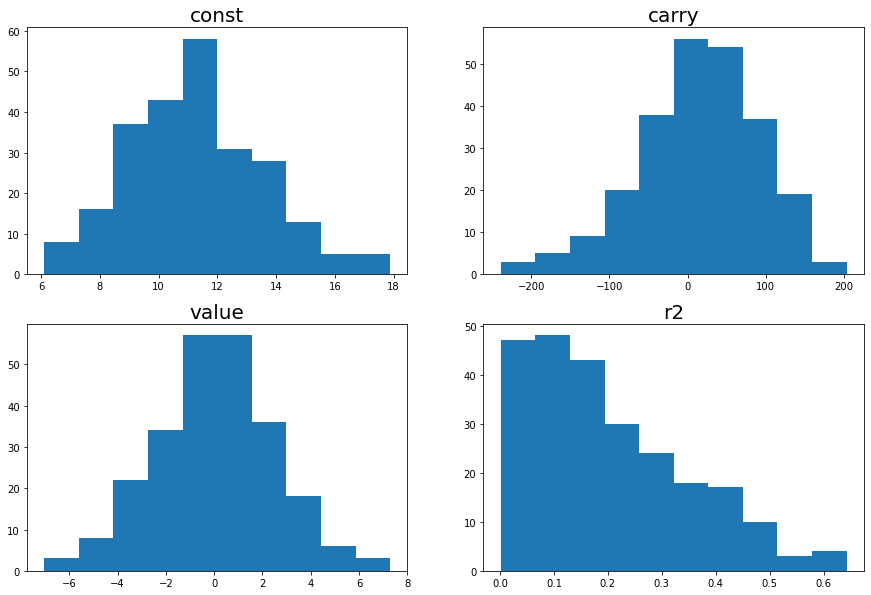

,const,carry,value,r2
count,244.000000,244.000000,244.000000,244.000000
mean,11.297154,14.115924,0.087984,0.200870
std,2.282400,77.963812,2.481662,0.145417
min,6.100100,-239.019222,-7.033495,0.001453
25%,9.665822,-31.165074,-1.477279,0.084802
50%,11.194856,21.771033,0.097218,0.165900
75%,12.858752,68.217016,1.664295,0.300861
max,17.880264,203.379593,7.288323,0.642885


In [18]:
pcsr = pd.DataFrame()
zeta = pd.DataFrame()
for t in pooled_data.index.get_level_values(0).unique():
    yt = pooled_data.loc[t].iloc[:,[0]].rank()
    xt = pooled_data.loc[t].iloc[:,[1,2]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HC3')
    coef = model.params.to_frame(t).T
    coef['r2'] = model.rsquared
    zeta = zeta.append((model.resid + model.params[0]).to_frame(t).T)
    pcsr = pcsr.append(coef)
    
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0, 0].hist(pcsr.iloc[:,[0]])
axs[0, 0].set_title(pcsr.columns[0], fontsize=20)
axs[0, 1].hist(pcsr.iloc[:,[1]])
axs[0, 1].set_title(pcsr.columns[1], fontsize=20)
axs[1, 0].hist(pcsr.iloc[:,[2]])
axs[1, 0].set_title(pcsr.columns[2], fontsize=20)
axs[1, 1].hist(pcsr.iloc[:,[3]])
axs[1, 1].set_title(pcsr.columns[3], fontsize=20)
plt.show()

pcsr.describe()

In [19]:
(pcsr.mean()/(pcsr.std()/np.sqrt(pcsr.count())))[['carry', 'value']]

carry    2.828207
value    0.553804
dtype: float64

###  Time series regressions

In the time-series regressions we assume:

* $\delta_{i,t} = \delta_{i}$ for all $t$
* $\xi_{t} = \xi_{i}$ for all $t$

So, we have the regression:

$$
y_{i,t} \equiv r_{i,t+h} = \delta_{i} + \xi_{i}'C_{i,t} + \eta_{i,t}.
$$

Note that since both $\delta_{i}$ and $\xi_{i}$ vary for every $i$, this regression is not exactly a panel regression with currency fixed effects. In fact, these are simply, a collection of regressions, one for each currency $i$. Each currency $i$ will produce different estimates for $\delta_{i}$ and $\xi_{i}$. Let's do that below and also estimate $\zeta_{i,t} = \delta_{i} + \eta_{i,t}$:

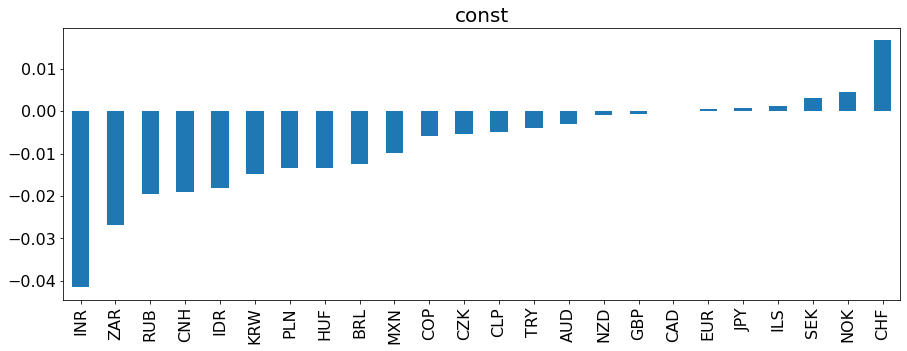

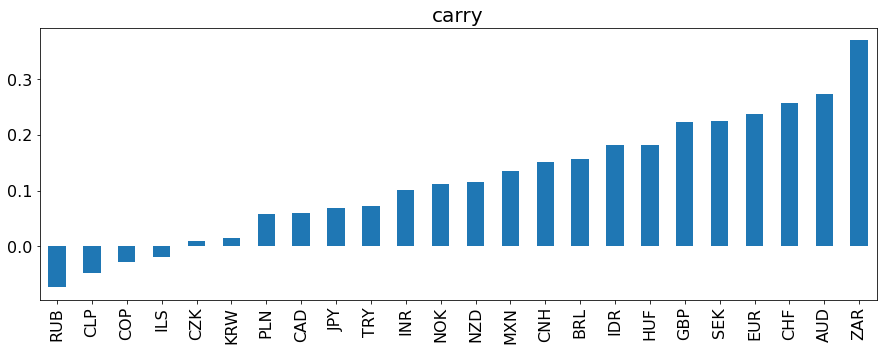

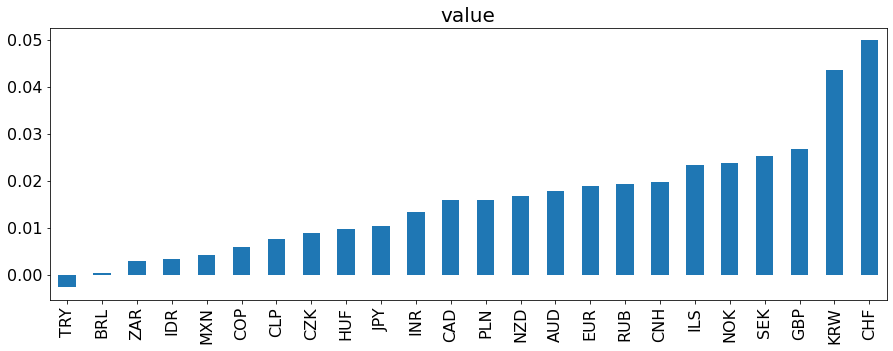

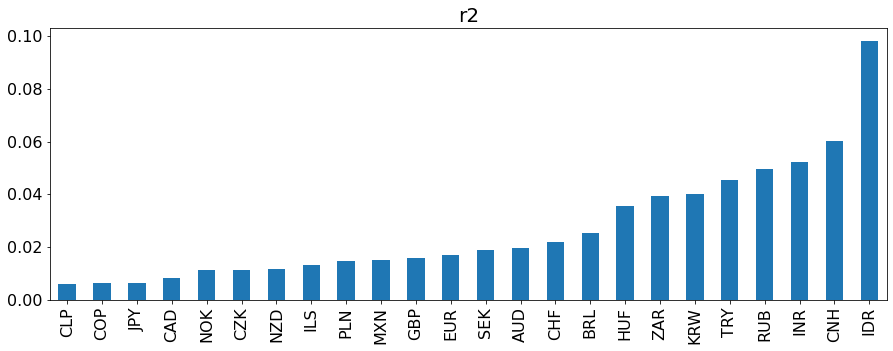

,const,carry,value,r2
count,24.000000,24.000000,24.000000,24.000000
mean,-0.007790,0.118327,0.015882,0.026818
std,0.012018,0.112996,0.012546,0.022148
min,-0.041582,-0.073535,-0.002688,0.006068
25%,-0.013780,0.048013,0.007258,0.011573
50%,-0.005219,0.113293,0.015961,0.017989
75%,0.000217,0.192186,0.020614,0.039522
max,0.016729,0.369939,0.049855,0.098130


In [20]:
pooled_data2 = pooled_data.copy().swaplevel(0,1)

pcsr = pd.DataFrame()
zeta = pd.DataFrame()
for t in pooled_data2.index.get_level_values(0).unique():
    yt = pooled_data2.loc[t].iloc[:,[0]]
    xt = pooled_data2.loc[t].iloc[:,[1,2]]
    model = sm.OLS(yt, sm.add_constant(xt)).fit(cov_type='HAC', cov_kwds={'maxlags':6})
    coef = model.params.to_frame(t).T
    coef['r2'] = model.rsquared
    zeta = zeta.append((model.resid + model.params[0]).to_frame(t).T)
    pcsr = pcsr.append(coef)
    
for i in range(pcsr.shape[1]):
    pcsr.iloc[:,i].sort_values().plot(kind='bar', figsize=(15,5), fontsize=16)
    plt.title(pcsr.columns[i], fontsize=20)
    plt.show()

pcsr.describe()

In [21]:
(pcsr.mean()/(pcsr.std()/np.sqrt(pcsr.count())))[['carry', 'value']]

carry    5.130108
value    6.201483
dtype: float64

### Exercise

You may want to look [here](https://bashtage.github.io/linearmodels/doc/asset-pricing/index.html) and try estimating the same regression with time fixed effects and/or currency fixed effects. What do you think the results suggest?